##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tuning a BERT model

In this example, we will work through fine-tuning a BERT model using the tensorflow-models PIP package.

The pretrained BERT model this tutorial is based on is also available on [TensorFlow Hub](https://tensorflow.org/hub), to see how to use it refer to the [Hub Appendix](#hub_bert)

## Setup

### Install the TensorFlow Model Garden pip package

*  `tf-models-official` is the stable Model Garden package. Note that it may not include the latest changes in the `tensorflow_models` github repo. To include latest changes, you may install `tf-models-nightly`,
which is the nightly Model Garden package created daily automatically.
*  pip will install all models and dependencies automatically.

In [2]:
!pip install -q -U tensorflow-text

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install -q tf-models-official==2.4.0

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


### Imports

In [4]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks


/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


### Resources

This directory contains the configuration, vocabulary, and a pre-trained checkpoint used in this tutorial:

In [5]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

You can get a pre-trained BERT encoder from [TensorFlow Hub](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2):

In [6]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

## The data
For this example we used the [GLUE MRPC dataset from TFDS](https://www.tensorflow.org/datasets/catalog/glue#gluemrpc).

This dataset is not set up so that it can be directly fed into the BERT model, so this section also handles the necessary preprocessing.

### Get the dataset from TensorFlow Datasets

The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent.

*   Number of labels: 2.
*   Size of training dataset: 3668.
*   Size of evaluation dataset: 408.
*   Maximum sequence length of training and evaluation dataset: 128.


In [7]:
glue, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


2021-08-19 11:26:56.046711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-19 11:26:56.055242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-19 11:26:56.056228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-19 11:26:56.057937: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2021-08-19 11:26:57.012380: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [8]:
list(glue.keys())

['train', 'validation', 'test']

The `info` object describes the dataset and it's features:

In [9]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

The two classes are:

In [10]:
info.features['label'].names

['not_equivalent', 'equivalent']

Here is one example from the training set:

In [11]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


### The BERT tokenizer

To fine tune a pre-trained model you need to be sure that you're using exactly the same tokenization, vocabulary, and index mapping as you used during training.

The BERT tokenizer used in this tutorial is written in pure Python (It's not built out of TensorFlow ops). So you can't just plug it into your model as a `keras.layer` like you can with `preprocessing.TextVectorization`.

The following code rebuilds the tokenizer that was used by the base model:

In [12]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


Tokenize a sentence:

In [13]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


### Preprocess the data

The section manually preprocessed the dataset into the format expected by the model.

This dataset is small, so preprocessing can be done quickly and easily in memory. For larger datasets the `tf_models` library includes some tools for preprocessing and re-serializing a dataset. See [Appendix: Re-encoding a large dataset](#re_encoding_tools) for details.

#### Encode the sentences

The model expects its two inputs sentences to be concatenated together. This input is expected to start with a `[CLS]` "This is a classification problem" token, and each sentence should end with a `[SEP]` "Separator" token:

In [14]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

Start by encoding all the sentences while appending a `[SEP]` token, and packing them into ragged-tensors:

In [15]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence1"]])
sentence2 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence2"]])

In [16]:
print("Sentence1 shape:", sentence1.shape.as_list())
print("Sentence2 shape:", sentence2.shape.as_list())

Sentence1 shape: [3668, None]
Sentence2 shape: [3668, None]


Now prepend a `[CLS]` token, and concatenate the ragged tensors to form a single `input_word_ids` tensor for each example. `RaggedTensor.to_tensor()` zero pads to the longest sequence.

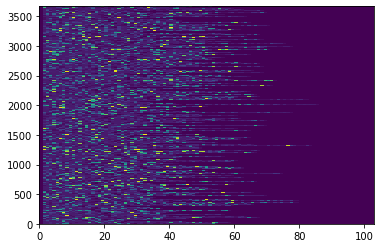

In [17]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

#### Mask and input type

The model expects two additional inputs:

* The input mask
* The input type

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding.

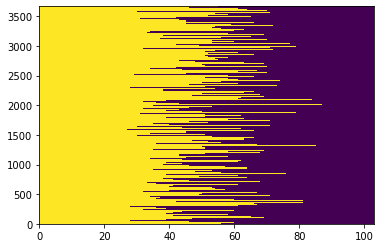

In [18]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

The "input type" also has the same shape, but inside the non-padded region, contains a `0` or a `1` indicating which sentence the token is a part of. 

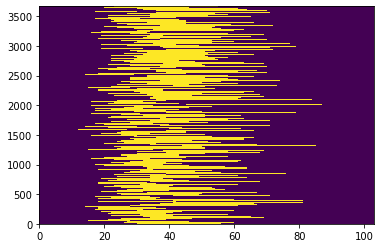

In [19]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

#### Put it all together

Collect the above text parsing code into a single function, and apply it to each split of the `glue/mrpc` dataset.

In [20]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [21]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

Each subset of the data has been converted to a dictionary of features, and a set of labels. Each feature in the input dictionary has the same shape, and the number of labels should match:

In [22]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue_train_labels shape: (3668,)


## The model

### Build the model


The first step is to download the configuration  for the pre-trained model.


In [23]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

The `config` defines the core BERT Model, which is a Keras model to predict the outputs of `num_classes` from the inputs with maximum sequence length `max_seq_length`.

This function returns both the encoder and the classifier.

In [24]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

The classifier has three inputs and one output:

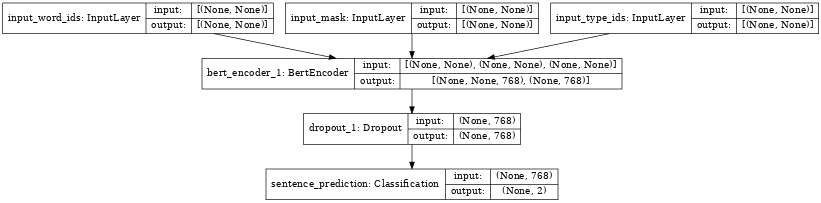

In [25]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

Run it on a test batch of data 10 examples from the training set. The output is the logits for the two classes:

In [26]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[-0.2307785 ,  0.14490062],
       [-0.09524915,  0.1295139 ],
       [-0.14503807,  0.19079085],
       [-0.2493319 ,  0.29745924],
       [-0.25108814, -0.09775029],
       [-0.02554443, -0.07443134],
       [-0.34417343,  0.00068308],
       [-0.13155738,  0.10524555],
       [-0.39608416, -0.14741066],
       [-0.2702508 , -0.02493864]], dtype=float32)

The `TransformerEncoder` in the center of the classifier above **is** the `bert_encoder`.

Inspecting the encoder, we see its stack of `Transformer` layers connected to those same three inputs:

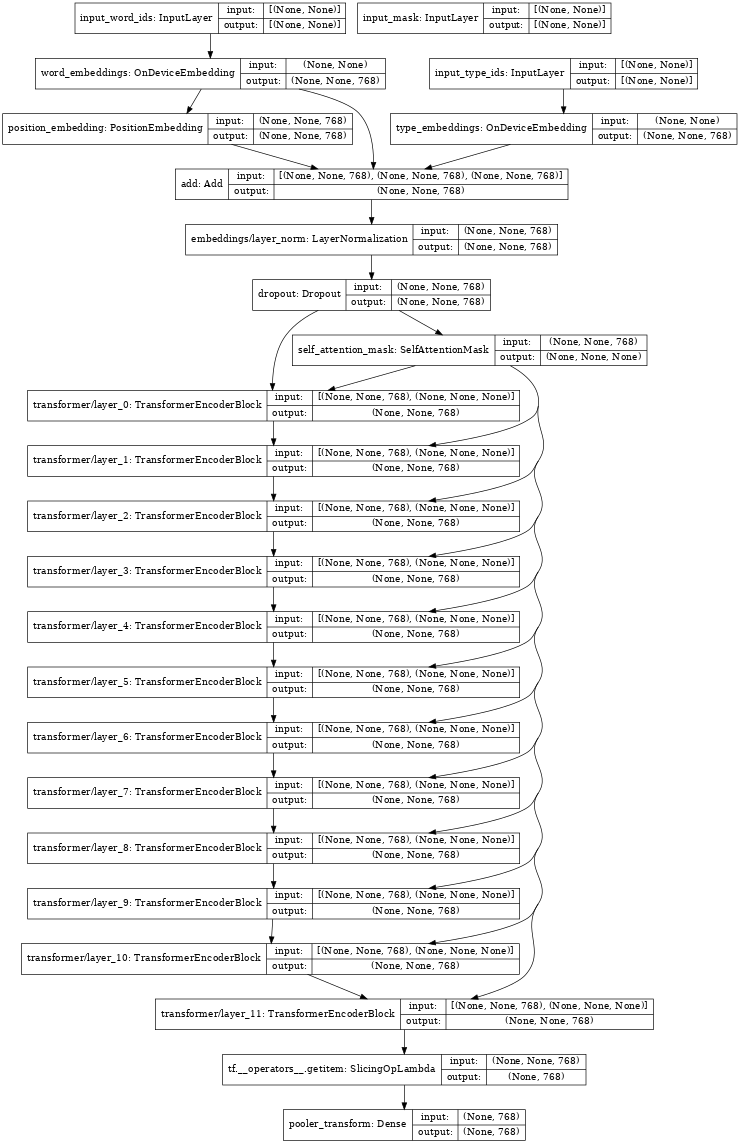

In [27]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

### Restore the encoder weights

When built the encoder is randomly initialized. Restore the encoder's weights from the checkpoint:

In [28]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Note: The pretrained `TransformerEncoder` is also available on [TensorFlow Hub](https://tensorflow.org/hub). See the [Hub appendix](#hub_bert) for details. 

### Set up the optimizer

BERT adopts the Adam optimizer with weight decay (aka "[AdamW](https://arxiv.org/abs/1711.05101)").
It also employs a learning rate schedule that firstly warms up from 0 and then decays to 0.

In [29]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

This returns an `AdamWeightDecay`  optimizer with the learning rate schedule set:

In [30]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

To see an example of how to customize the optimizer and it's schedule, see the [Optimizer schedule appendix](#optimizer_schedule).

### Train the model

The metric is accuracy and we use sparse categorical cross-entropy as loss.

In [31]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3



  1/115 [..............................] - ETA: 24:36 - loss: 0.6862 - accuracy: 0.5000


  2/115 [..............................] - ETA: 23s - loss: 0.6825 - accuracy: 0.5469  


  3/115 [..............................] - ETA: 23s - loss: 0.6914 - accuracy: 0.5104


  4/115 [>.............................] - ETA: 22s - loss: 0.6926 - accuracy: 0.5312


  5/115 [>.............................] - ETA: 22s - loss: 0.6900 - accuracy: 0.5437


  6/115 [>.............................] - ETA: 22s - loss: 0.6896 - accuracy: 0.5573


  7/115 [>.............................] - ETA: 22s - loss: 0.6887 - accuracy: 0.5491


  8/115 [=>............................] - ETA: 22s - loss: 0.6917 - accuracy: 0.5391


  9/115 [=>............................] - ETA: 21s - loss: 0.6939 - accuracy: 0.5208


 10/115 [=>............................] - ETA: 21s - loss: 0.6913 - accuracy: 0.5312


 11/115 [=>............................] - ETA: 21s - loss: 0.6893 - accuracy: 0.5312


 12/115 [==>...........................] - ETA: 21s - loss: 0.6900 - accuracy: 0.5339


 13/115 [==>...........................] - ETA: 21s - loss: 0.6899 - accuracy: 0.5337


 14/115 [==>...........................] - ETA: 20s - loss: 0.6854 - accuracy: 0.5491


 15/115 [==>...........................] - ETA: 20s - loss: 0.6838 - accuracy: 0.5521


 16/115 [===>..........................] - ETA: 20s - loss: 0.6791 - accuracy: 0.5723


 17/115 [===>..........................] - ETA: 20s - loss: 0.6781 - accuracy: 0.5754


 18/115 [===>..........................] - ETA: 19s - loss: 0.6786 - accuracy: 0.5729


 19/115 [===>..........................] - ETA: 19s - loss: 0.6779 - accuracy: 0.5757


 20/115 [====>.........................] - ETA: 19s - loss: 0.6768 - accuracy: 0.5781


 21/115 [====>.........................] - ETA: 19s - loss: 0.6805 - accuracy: 0.5685


 22/115 [====>.........................] - ETA: 19s - loss: 0.6792 - accuracy: 0.5710


 23/115 [=====>........................] - ETA: 18s - loss: 0.6790 - accuracy: 0.5747


 24/115 [=====>........................] - ETA: 18s - loss: 0.6781 - accuracy: 0.5781


 25/115 [=====>........................] - ETA: 18s - loss: 0.6756 - accuracy: 0.5838


 26/115 [=====>........................] - ETA: 18s - loss: 0.6744 - accuracy: 0.5877


 27/115 [======>.......................] - ETA: 18s - loss: 0.6745 - accuracy: 0.5868


 28/115 [======>.......................] - ETA: 17s - loss: 0.6742 - accuracy: 0.5882


 29/115 [======>.......................] - ETA: 17s - loss: 0.6703 - accuracy: 0.5948


 30/115 [======>.......................] - ETA: 17s - loss: 0.6708 - accuracy: 0.5927


 31/115 [=======>......................] - ETA: 17s - loss: 0.6695 - accuracy: 0.5938


 32/115 [=======>......................] - ETA: 17s - loss: 0.6703 - accuracy: 0.5928


 33/115 [=======>......................] - ETA: 16s - loss: 0.6700 - accuracy: 0.5947


 34/115 [=======>......................] - ETA: 16s - loss: 0.6702 - accuracy: 0.5938


 35/115 [========>.....................] - ETA: 16s - loss: 0.6725 - accuracy: 0.5911


 36/115 [========>.....................] - ETA: 16s - loss: 0.6692 - accuracy: 0.5972


 37/115 [========>.....................] - ETA: 16s - loss: 0.6679 - accuracy: 0.6005


 38/115 [========>.....................] - ETA: 15s - loss: 0.6657 - accuracy: 0.6036


 39/115 [=========>....................] - ETA: 15s - loss: 0.6655 - accuracy: 0.6042


 40/115 [=========>....................] - ETA: 15s - loss: 0.6687 - accuracy: 0.6008


 41/115 [=========>....................] - ETA: 15s - loss: 0.6670 - accuracy: 0.6029


 42/115 [=========>....................] - ETA: 15s - loss: 0.6658 - accuracy: 0.6057


 43/115 [==========>...................] - ETA: 14s - loss: 0.6657 - accuracy: 0.6068


 44/115 [==========>...................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6094


 45/115 [==========>...................] - ETA: 14s - loss: 0.6627 - accuracy: 0.6104


 46/115 [===========>..................] - ETA: 14s - loss: 0.6622 - accuracy: 0.6114


 47/115 [===========>..................] - ETA: 13s - loss: 0.6607 - accuracy: 0.6137


 48/115 [===========>..................] - ETA: 13s - loss: 0.6589 - accuracy: 0.6165


 49/115 [===========>..................] - ETA: 13s - loss: 0.6574 - accuracy: 0.6193


 50/115 [============>.................] - ETA: 13s - loss: 0.6563 - accuracy: 0.6206


 51/115 [============>.................] - ETA: 13s - loss: 0.6563 - accuracy: 0.6213


 52/115 [============>.................] - ETA: 12s - loss: 0.6552 - accuracy: 0.6238


 53/115 [============>.................] - ETA: 12s - loss: 0.6543 - accuracy: 0.6250


 54/115 [=============>................] - ETA: 12s - loss: 0.6534 - accuracy: 0.6267


 55/115 [=============>................] - ETA: 12s - loss: 0.6529 - accuracy: 0.6273


 56/115 [=============>................] - ETA: 12s - loss: 0.6525 - accuracy: 0.6278


 57/115 [=============>................] - ETA: 11s - loss: 0.6499 - accuracy: 0.6305


 58/115 [==============>...............] - ETA: 11s - loss: 0.6480 - accuracy: 0.6325


 59/115 [==============>...............] - ETA: 11s - loss: 0.6469 - accuracy: 0.6340


 60/115 [==============>...............] - ETA: 11s - loss: 0.6482 - accuracy: 0.6323


 61/115 [==============>...............] - ETA: 11s - loss: 0.6482 - accuracy: 0.6327


 62/115 [===============>..............] - ETA: 10s - loss: 0.6484 - accuracy: 0.6331


 63/115 [===============>..............] - ETA: 10s - loss: 0.6462 - accuracy: 0.6349


 64/115 [===============>..............] - ETA: 10s - loss: 0.6475 - accuracy: 0.6338


 65/115 [===============>..............] - ETA: 10s - loss: 0.6458 - accuracy: 0.6356


 66/115 [================>.............] - ETA: 10s - loss: 0.6452 - accuracy: 0.6359


 67/115 [================>.............] - ETA: 9s - loss: 0.6440 - accuracy: 0.6381 


 68/115 [================>.............] - ETA: 9s - loss: 0.6436 - accuracy: 0.6383


 69/115 [=================>............] - ETA: 9s - loss: 0.6440 - accuracy: 0.6372


 70/115 [=================>............] - ETA: 9s - loss: 0.6430 - accuracy: 0.6384


 71/115 [=================>............] - ETA: 9s - loss: 0.6417 - accuracy: 0.6400


 72/115 [=================>............] - ETA: 8s - loss: 0.6414 - accuracy: 0.6402


 73/115 [==================>...........] - ETA: 8s - loss: 0.6424 - accuracy: 0.6400


 74/115 [==================>...........] - ETA: 8s - loss: 0.6424 - accuracy: 0.6394


 75/115 [==================>...........] - ETA: 8s - loss: 0.6416 - accuracy: 0.6408


 76/115 [==================>...........] - ETA: 8s - loss: 0.6407 - accuracy: 0.6419


 77/115 [===================>..........] - ETA: 7s - loss: 0.6402 - accuracy: 0.6425


 78/115 [===================>..........] - ETA: 7s - loss: 0.6374 - accuracy: 0.6450


 79/115 [===================>..........] - ETA: 7s - loss: 0.6365 - accuracy: 0.6456


 80/115 [===================>..........] - ETA: 7s - loss: 0.6344 - accuracy: 0.6477


 81/115 [====================>.........] - ETA: 6s - loss: 0.6338 - accuracy: 0.6478


 82/115 [====================>.........] - ETA: 6s - loss: 0.6332 - accuracy: 0.6486


 83/115 [====================>.........] - ETA: 6s - loss: 0.6317 - accuracy: 0.6498


 84/115 [====================>.........] - ETA: 6s - loss: 0.6293 - accuracy: 0.6518


 85/115 [=====================>........] - ETA: 6s - loss: 0.6286 - accuracy: 0.6518


 86/115 [=====================>........] - ETA: 5s - loss: 0.6289 - accuracy: 0.6512


 87/115 [=====================>........] - ETA: 5s - loss: 0.6276 - accuracy: 0.6523


 88/115 [=====================>........] - ETA: 5s - loss: 0.6265 - accuracy: 0.6534


 89/115 [======================>.......] - ETA: 5s - loss: 0.6267 - accuracy: 0.6538


 90/115 [======================>.......] - ETA: 5s - loss: 0.6258 - accuracy: 0.6542


 91/115 [======================>.......] - ETA: 4s - loss: 0.6248 - accuracy: 0.6552


 92/115 [=======================>......] - ETA: 4s - loss: 0.6239 - accuracy: 0.6569


 93/115 [=======================>......] - ETA: 4s - loss: 0.6225 - accuracy: 0.6576


 94/115 [=======================>......] - ETA: 4s - loss: 0.6212 - accuracy: 0.6586


 95/115 [=======================>......] - ETA: 4s - loss: 0.6197 - accuracy: 0.6602


 96/115 [========================>.....] - ETA: 3s - loss: 0.6171 - accuracy: 0.6624


 97/115 [========================>.....] - ETA: 3s - loss: 0.6160 - accuracy: 0.6633


 98/115 [========================>.....] - ETA: 3s - loss: 0.6163 - accuracy: 0.6629


 99/115 [========================>.....] - ETA: 3s - loss: 0.6147 - accuracy: 0.6641


100/115 [=========================>....] - ETA: 3s - loss: 0.6158 - accuracy: 0.6641


101/115 [=========================>....] - ETA: 2s - loss: 0.6169 - accuracy: 0.6643


102/115 [=========================>....] - ETA: 2s - loss: 0.6167 - accuracy: 0.6648


103/115 [=========================>....] - ETA: 2s - loss: 0.6169 - accuracy: 0.6644


104/115 [==========================>...] - ETA: 2s - loss: 0.6172 - accuracy: 0.6647


105/115 [==========================>...] - ETA: 2s - loss: 0.6146 - accuracy: 0.6673


106/115 [==========================>...] - ETA: 1s - loss: 0.6142 - accuracy: 0.6683


107/115 [==========================>...] - ETA: 1s - loss: 0.6121 - accuracy: 0.6706


108/115 [===========================>..] - ETA: 1s - loss: 0.6122 - accuracy: 0.6704


109/115 [===========================>..] - ETA: 1s - loss: 0.6111 - accuracy: 0.6712


110/115 [===========================>..] - ETA: 1s - loss: 0.6106 - accuracy: 0.6713


111/115 [===========================>..] - ETA: 0s - loss: 0.6100 - accuracy: 0.6709


112/115 [============================>.] - ETA: 0s - loss: 0.6089 - accuracy: 0.6722


113/115 [============================>.] - ETA: 0s - loss: 0.6078 - accuracy: 0.6731


114/115 [============================>.] - ETA: 0s - loss: 0.6068 - accuracy: 0.6735


115/115 [==============================] - ETA: 0s - loss: 0.6067 - accuracy: 0.6737


115/115 [==============================] - 38s 222ms/step - loss: 0.6067 - accuracy: 0.6737 - val_loss: 0.5166 - val_accuracy: 0.7574


Epoch 2/3



  1/115 [..............................] - ETA: 23s - loss: 0.3825 - accuracy: 0.7812


  2/115 [..............................] - ETA: 23s - loss: 0.3963 - accuracy: 0.8125


  3/115 [..............................] - ETA: 22s - loss: 0.4203 - accuracy: 0.8229


  4/115 [>.............................] - ETA: 22s - loss: 0.4291 - accuracy: 0.8203


  5/115 [>.............................] - ETA: 22s - loss: 0.4367 - accuracy: 0.8125


  6/115 [>.............................] - ETA: 22s - loss: 0.4432 - accuracy: 0.8021


  7/115 [>.............................] - ETA: 22s - loss: 0.4413 - accuracy: 0.8036


  8/115 [=>............................] - ETA: 21s - loss: 0.4550 - accuracy: 0.7969


  9/115 [=>............................] - ETA: 21s - loss: 0.4654 - accuracy: 0.7847


 10/115 [=>............................] - ETA: 21s - loss: 0.4701 - accuracy: 0.7844


 11/115 [=>............................] - ETA: 21s - loss: 0.4725 - accuracy: 0.7869


 12/115 [==>...........................] - ETA: 21s - loss: 0.4813 - accuracy: 0.7786


 13/115 [==>...........................] - ETA: 20s - loss: 0.4770 - accuracy: 0.7812


 14/115 [==>...........................] - ETA: 20s - loss: 0.4857 - accuracy: 0.7723


 15/115 [==>...........................] - ETA: 20s - loss: 0.4890 - accuracy: 0.7688


 16/115 [===>..........................] - ETA: 20s - loss: 0.4904 - accuracy: 0.7637


 17/115 [===>..........................] - ETA: 20s - loss: 0.4928 - accuracy: 0.7629


 18/115 [===>..........................] - ETA: 19s - loss: 0.4903 - accuracy: 0.7622


 19/115 [===>..........................] - ETA: 19s - loss: 0.4908 - accuracy: 0.7632


 20/115 [====>.........................] - ETA: 19s - loss: 0.4836 - accuracy: 0.7703


 21/115 [====>.........................] - ETA: 19s - loss: 0.4844 - accuracy: 0.7708


 22/115 [====>.........................] - ETA: 19s - loss: 0.4795 - accuracy: 0.7756


 23/115 [=====>........................] - ETA: 18s - loss: 0.4824 - accuracy: 0.7758


 24/115 [=====>........................] - ETA: 18s - loss: 0.4847 - accuracy: 0.7721


 25/115 [=====>........................] - ETA: 18s - loss: 0.4883 - accuracy: 0.7700


 26/115 [=====>........................] - ETA: 18s - loss: 0.4900 - accuracy: 0.7704


 27/115 [======>.......................] - ETA: 18s - loss: 0.4866 - accuracy: 0.7720


 28/115 [======>.......................] - ETA: 17s - loss: 0.4851 - accuracy: 0.7712


 29/115 [======>.......................] - ETA: 17s - loss: 0.4821 - accuracy: 0.7726


 30/115 [======>.......................] - ETA: 17s - loss: 0.4754 - accuracy: 0.7802


 31/115 [=======>......................] - ETA: 17s - loss: 0.4737 - accuracy: 0.7802


 32/115 [=======>......................] - ETA: 17s - loss: 0.4747 - accuracy: 0.7812


 33/115 [=======>......................] - ETA: 16s - loss: 0.4733 - accuracy: 0.7831


 34/115 [=======>......................] - ETA: 16s - loss: 0.4708 - accuracy: 0.7831


 35/115 [========>.....................] - ETA: 16s - loss: 0.4721 - accuracy: 0.7821


 36/115 [========>.....................] - ETA: 16s - loss: 0.4754 - accuracy: 0.7795


 37/115 [========>.....................] - ETA: 16s - loss: 0.4762 - accuracy: 0.7762


 38/115 [========>.....................] - ETA: 15s - loss: 0.4729 - accuracy: 0.7796


 39/115 [=========>....................] - ETA: 15s - loss: 0.4727 - accuracy: 0.7788


 40/115 [=========>....................] - ETA: 15s - loss: 0.4726 - accuracy: 0.7797


 41/115 [=========>....................] - ETA: 15s - loss: 0.4712 - accuracy: 0.7820


 42/115 [=========>....................] - ETA: 14s - loss: 0.4698 - accuracy: 0.7842


 43/115 [==========>...................] - ETA: 14s - loss: 0.4719 - accuracy: 0.7834


 44/115 [==========>...................] - ETA: 14s - loss: 0.4725 - accuracy: 0.7827


 45/115 [==========>...................] - ETA: 14s - loss: 0.4703 - accuracy: 0.7847


 46/115 [===========>..................] - ETA: 14s - loss: 0.4711 - accuracy: 0.7833


 47/115 [===========>..................] - ETA: 13s - loss: 0.4714 - accuracy: 0.7832


 48/115 [===========>..................] - ETA: 13s - loss: 0.4710 - accuracy: 0.7826


 49/115 [===========>..................] - ETA: 13s - loss: 0.4707 - accuracy: 0.7832


 50/115 [============>.................] - ETA: 13s - loss: 0.4722 - accuracy: 0.7831


 51/115 [============>.................] - ETA: 13s - loss: 0.4722 - accuracy: 0.7837


 52/115 [============>.................] - ETA: 12s - loss: 0.4726 - accuracy: 0.7843


 53/115 [============>.................] - ETA: 12s - loss: 0.4740 - accuracy: 0.7830


 54/115 [=============>................] - ETA: 12s - loss: 0.4735 - accuracy: 0.7836


 55/115 [=============>................] - ETA: 12s - loss: 0.4726 - accuracy: 0.7841


 56/115 [=============>................] - ETA: 12s - loss: 0.4714 - accuracy: 0.7852


 57/115 [=============>................] - ETA: 11s - loss: 0.4709 - accuracy: 0.7851


 58/115 [==============>...............] - ETA: 11s - loss: 0.4693 - accuracy: 0.7866


 59/115 [==============>...............] - ETA: 11s - loss: 0.4693 - accuracy: 0.7865


 60/115 [==============>...............] - ETA: 11s - loss: 0.4667 - accuracy: 0.7891


 61/115 [==============>...............] - ETA: 11s - loss: 0.4638 - accuracy: 0.7905


 62/115 [===============>..............] - ETA: 10s - loss: 0.4632 - accuracy: 0.7913


 63/115 [===============>..............] - ETA: 10s - loss: 0.4629 - accuracy: 0.7917


 64/115 [===============>..............] - ETA: 10s - loss: 0.4612 - accuracy: 0.7930


 65/115 [===============>..............] - ETA: 10s - loss: 0.4614 - accuracy: 0.7923


 66/115 [================>.............] - ETA: 10s - loss: 0.4608 - accuracy: 0.7926


 67/115 [================>.............] - ETA: 9s - loss: 0.4598 - accuracy: 0.7934 


 68/115 [================>.............] - ETA: 9s - loss: 0.4612 - accuracy: 0.7923


 69/115 [=================>............] - ETA: 9s - loss: 0.4615 - accuracy: 0.7912


 70/115 [=================>............] - ETA: 9s - loss: 0.4594 - accuracy: 0.7924


 71/115 [=================>............] - ETA: 9s - loss: 0.4595 - accuracy: 0.7923


 72/115 [=================>............] - ETA: 8s - loss: 0.4576 - accuracy: 0.7934


 73/115 [==================>...........] - ETA: 8s - loss: 0.4566 - accuracy: 0.7945


 74/115 [==================>...........] - ETA: 8s - loss: 0.4558 - accuracy: 0.7952


 75/115 [==================>...........] - ETA: 8s - loss: 0.4548 - accuracy: 0.7962


 76/115 [==================>...........] - ETA: 8s - loss: 0.4548 - accuracy: 0.7965


 77/115 [===================>..........] - ETA: 7s - loss: 0.4529 - accuracy: 0.7975


 78/115 [===================>..........] - ETA: 7s - loss: 0.4507 - accuracy: 0.7989


 79/115 [===================>..........] - ETA: 7s - loss: 0.4499 - accuracy: 0.7987


 80/115 [===================>..........] - ETA: 7s - loss: 0.4497 - accuracy: 0.7992


 81/115 [====================>.........] - ETA: 6s - loss: 0.4477 - accuracy: 0.8009


 82/115 [====================>.........] - ETA: 6s - loss: 0.4468 - accuracy: 0.8018


 83/115 [====================>.........] - ETA: 6s - loss: 0.4472 - accuracy: 0.8020


 84/115 [====================>.........] - ETA: 6s - loss: 0.4455 - accuracy: 0.8028


 85/115 [=====================>........] - ETA: 6s - loss: 0.4458 - accuracy: 0.8018


 86/115 [=====================>........] - ETA: 5s - loss: 0.4447 - accuracy: 0.8023


 87/115 [=====================>........] - ETA: 5s - loss: 0.4443 - accuracy: 0.8024


 88/115 [=====================>........] - ETA: 5s - loss: 0.4443 - accuracy: 0.8026


 89/115 [======================>.......] - ETA: 5s - loss: 0.4433 - accuracy: 0.8030


 90/115 [======================>.......] - ETA: 5s - loss: 0.4437 - accuracy: 0.8028


 91/115 [======================>.......] - ETA: 4s - loss: 0.4428 - accuracy: 0.8032


 92/115 [=======================>......] - ETA: 4s - loss: 0.4418 - accuracy: 0.8033


 93/115 [=======================>......] - ETA: 4s - loss: 0.4419 - accuracy: 0.8044


 94/115 [=======================>......] - ETA: 4s - loss: 0.4414 - accuracy: 0.8045


 95/115 [=======================>......] - ETA: 4s - loss: 0.4407 - accuracy: 0.8053


 96/115 [========================>.....] - ETA: 3s - loss: 0.4394 - accuracy: 0.8053


 97/115 [========================>.....] - ETA: 3s - loss: 0.4375 - accuracy: 0.8067


 98/115 [========================>.....] - ETA: 3s - loss: 0.4376 - accuracy: 0.8064


 99/115 [========================>.....] - ETA: 3s - loss: 0.4373 - accuracy: 0.8068


100/115 [=========================>....] - ETA: 3s - loss: 0.4366 - accuracy: 0.8069


101/115 [=========================>....] - ETA: 2s - loss: 0.4382 - accuracy: 0.8060


102/115 [=========================>....] - ETA: 2s - loss: 0.4375 - accuracy: 0.8064


103/115 [=========================>....] - ETA: 2s - loss: 0.4364 - accuracy: 0.8070


104/115 [==========================>...] - ETA: 2s - loss: 0.4362 - accuracy: 0.8068


105/115 [==========================>...] - ETA: 2s - loss: 0.4354 - accuracy: 0.8080


106/115 [==========================>...] - ETA: 1s - loss: 0.4352 - accuracy: 0.8075


107/115 [==========================>...] - ETA: 1s - loss: 0.4355 - accuracy: 0.8070


108/115 [===========================>..] - ETA: 1s - loss: 0.4368 - accuracy: 0.8061


109/115 [===========================>..] - ETA: 1s - loss: 0.4368 - accuracy: 0.8062


110/115 [===========================>..] - ETA: 1s - loss: 0.4365 - accuracy: 0.8062


111/115 [===========================>..] - ETA: 0s - loss: 0.4369 - accuracy: 0.8057


112/115 [============================>.] - ETA: 0s - loss: 0.4383 - accuracy: 0.8050


113/115 [============================>.] - ETA: 0s - loss: 0.4369 - accuracy: 0.8059


114/115 [============================>.] - ETA: 0s - loss: 0.4363 - accuracy: 0.8062


115/115 [==============================] - ETA: 0s - loss: 0.4362 - accuracy: 0.8062


115/115 [==============================] - 24s 211ms/step - loss: 0.4362 - accuracy: 0.8062 - val_loss: 0.3850 - val_accuracy: 0.8137


Epoch 3/3



  1/115 [..............................] - ETA: 23s - loss: 0.2653 - accuracy: 0.9062


  2/115 [..............................] - ETA: 23s - loss: 0.2498 - accuracy: 0.9219


  3/115 [..............................] - ETA: 22s - loss: 0.2544 - accuracy: 0.9167


  4/115 [>.............................] - ETA: 22s - loss: 0.2682 - accuracy: 0.9062


  5/115 [>.............................] - ETA: 22s - loss: 0.2634 - accuracy: 0.9125


  6/115 [>.............................] - ETA: 22s - loss: 0.2472 - accuracy: 0.9219


  7/115 [>.............................] - ETA: 22s - loss: 0.2493 - accuracy: 0.9152


  8/115 [=>............................] - ETA: 21s - loss: 0.2679 - accuracy: 0.9102


  9/115 [=>............................] - ETA: 21s - loss: 0.2684 - accuracy: 0.9097


 10/115 [=>............................] - ETA: 21s - loss: 0.2775 - accuracy: 0.9031


 11/115 [=>............................] - ETA: 21s - loss: 0.2785 - accuracy: 0.9034


 12/115 [==>...........................] - ETA: 21s - loss: 0.2819 - accuracy: 0.9010


 13/115 [==>...........................] - ETA: 20s - loss: 0.2746 - accuracy: 0.9062


 14/115 [==>...........................] - ETA: 20s - loss: 0.2842 - accuracy: 0.8996


 15/115 [==>...........................] - ETA: 20s - loss: 0.2870 - accuracy: 0.8979


 16/115 [===>..........................] - ETA: 20s - loss: 0.2835 - accuracy: 0.8984


 17/115 [===>..........................] - ETA: 20s - loss: 0.2838 - accuracy: 0.8971


 18/115 [===>..........................] - ETA: 19s - loss: 0.2891 - accuracy: 0.8976


 19/115 [===>..........................] - ETA: 19s - loss: 0.2932 - accuracy: 0.8914


 20/115 [====>.........................] - ETA: 19s - loss: 0.2962 - accuracy: 0.8891


 21/115 [====>.........................] - ETA: 19s - loss: 0.2905 - accuracy: 0.8943


 22/115 [====>.........................] - ETA: 19s - loss: 0.2970 - accuracy: 0.8906


 23/115 [=====>........................] - ETA: 18s - loss: 0.3029 - accuracy: 0.8886


 24/115 [=====>........................] - ETA: 18s - loss: 0.2979 - accuracy: 0.8919


 25/115 [=====>........................] - ETA: 18s - loss: 0.3004 - accuracy: 0.8888


 26/115 [=====>........................] - ETA: 18s - loss: 0.2966 - accuracy: 0.8906


 27/115 [======>.......................] - ETA: 18s - loss: 0.2958 - accuracy: 0.8912


 28/115 [======>.......................] - ETA: 17s - loss: 0.2963 - accuracy: 0.8906


 29/115 [======>.......................] - ETA: 17s - loss: 0.2949 - accuracy: 0.8933


 30/115 [======>.......................] - ETA: 17s - loss: 0.2981 - accuracy: 0.8917


 31/115 [=======>......................] - ETA: 17s - loss: 0.3015 - accuracy: 0.8901


 32/115 [=======>......................] - ETA: 17s - loss: 0.3017 - accuracy: 0.8887


 33/115 [=======>......................] - ETA: 16s - loss: 0.3044 - accuracy: 0.8854


 34/115 [=======>......................] - ETA: 16s - loss: 0.3028 - accuracy: 0.8851


 35/115 [========>.....................] - ETA: 16s - loss: 0.3024 - accuracy: 0.8866


 36/115 [========>.....................] - ETA: 16s - loss: 0.3039 - accuracy: 0.8837


 37/115 [========>.....................] - ETA: 15s - loss: 0.3026 - accuracy: 0.8834


 38/115 [========>.....................] - ETA: 15s - loss: 0.3015 - accuracy: 0.8849


 39/115 [=========>....................] - ETA: 15s - loss: 0.3009 - accuracy: 0.8862


 40/115 [=========>....................] - ETA: 15s - loss: 0.2980 - accuracy: 0.8883


 41/115 [=========>....................] - ETA: 15s - loss: 0.2976 - accuracy: 0.8887


 42/115 [=========>....................] - ETA: 14s - loss: 0.2989 - accuracy: 0.8891


 43/115 [==========>...................] - ETA: 14s - loss: 0.2986 - accuracy: 0.8888


 44/115 [==========>...................] - ETA: 14s - loss: 0.2999 - accuracy: 0.8892


 45/115 [==========>...................] - ETA: 14s - loss: 0.3011 - accuracy: 0.8882


 46/115 [===========>..................] - ETA: 14s - loss: 0.3018 - accuracy: 0.8872


 47/115 [===========>..................] - ETA: 13s - loss: 0.3020 - accuracy: 0.8863


 48/115 [===========>..................] - ETA: 13s - loss: 0.3031 - accuracy: 0.8854


 49/115 [===========>..................] - ETA: 13s - loss: 0.3031 - accuracy: 0.8852


 50/115 [============>.................] - ETA: 13s - loss: 0.3024 - accuracy: 0.8863


 51/115 [============>.................] - ETA: 13s - loss: 0.3010 - accuracy: 0.8873


 52/115 [============>.................] - ETA: 12s - loss: 0.3027 - accuracy: 0.8870


 53/115 [============>.................] - ETA: 12s - loss: 0.3016 - accuracy: 0.8868


 54/115 [=============>................] - ETA: 12s - loss: 0.3018 - accuracy: 0.8866


 55/115 [=============>................] - ETA: 12s - loss: 0.3029 - accuracy: 0.8858


 56/115 [=============>................] - ETA: 12s - loss: 0.3046 - accuracy: 0.8834


 57/115 [=============>................] - ETA: 11s - loss: 0.3023 - accuracy: 0.8849


 58/115 [==============>...............] - ETA: 11s - loss: 0.3000 - accuracy: 0.8858


 59/115 [==============>...............] - ETA: 11s - loss: 0.2985 - accuracy: 0.8867


 60/115 [==============>...............] - ETA: 11s - loss: 0.2990 - accuracy: 0.8870


 61/115 [==============>...............] - ETA: 11s - loss: 0.2993 - accuracy: 0.8873


 62/115 [===============>..............] - ETA: 10s - loss: 0.3013 - accuracy: 0.8861


 63/115 [===============>..............] - ETA: 10s - loss: 0.3017 - accuracy: 0.8859


 64/115 [===============>..............] - ETA: 10s - loss: 0.3000 - accuracy: 0.8877


 65/115 [===============>..............] - ETA: 10s - loss: 0.3020 - accuracy: 0.8870


 66/115 [================>.............] - ETA: 10s - loss: 0.2995 - accuracy: 0.8887


 67/115 [================>.............] - ETA: 9s - loss: 0.2973 - accuracy: 0.8904 


 68/115 [================>.............] - ETA: 9s - loss: 0.2989 - accuracy: 0.8897


 69/115 [=================>............] - ETA: 9s - loss: 0.2987 - accuracy: 0.8899


 70/115 [=================>............] - ETA: 9s - loss: 0.2984 - accuracy: 0.8897


 71/115 [=================>............] - ETA: 9s - loss: 0.2994 - accuracy: 0.8895


 72/115 [=================>............] - ETA: 8s - loss: 0.2998 - accuracy: 0.8898


 73/115 [==================>...........] - ETA: 8s - loss: 0.2998 - accuracy: 0.8900


 74/115 [==================>...........] - ETA: 8s - loss: 0.3005 - accuracy: 0.8898


 75/115 [==================>...........] - ETA: 8s - loss: 0.2988 - accuracy: 0.8904


 76/115 [==================>...........] - ETA: 8s - loss: 0.2979 - accuracy: 0.8910


 77/115 [===================>..........] - ETA: 7s - loss: 0.2959 - accuracy: 0.8925


 78/115 [===================>..........] - ETA: 7s - loss: 0.2950 - accuracy: 0.8930


 79/115 [===================>..........] - ETA: 7s - loss: 0.2941 - accuracy: 0.8936


 80/115 [===================>..........] - ETA: 7s - loss: 0.2937 - accuracy: 0.8941


 81/115 [====================>.........] - ETA: 6s - loss: 0.2933 - accuracy: 0.8943


 82/115 [====================>.........] - ETA: 6s - loss: 0.2943 - accuracy: 0.8941


 83/115 [====================>.........] - ETA: 6s - loss: 0.2935 - accuracy: 0.8942


 84/115 [====================>.........] - ETA: 6s - loss: 0.2936 - accuracy: 0.8936


 85/115 [=====================>........] - ETA: 6s - loss: 0.2936 - accuracy: 0.8934


 86/115 [=====================>........] - ETA: 5s - loss: 0.2938 - accuracy: 0.8928


 87/115 [=====================>........] - ETA: 5s - loss: 0.2939 - accuracy: 0.8926


 88/115 [=====================>........] - ETA: 5s - loss: 0.2931 - accuracy: 0.8931


 89/115 [======================>.......] - ETA: 5s - loss: 0.2923 - accuracy: 0.8940


 90/115 [======================>.......] - ETA: 5s - loss: 0.2937 - accuracy: 0.8931


 91/115 [======================>.......] - ETA: 4s - loss: 0.2938 - accuracy: 0.8935


 92/115 [=======================>......] - ETA: 4s - loss: 0.2959 - accuracy: 0.8923


 93/115 [=======================>......] - ETA: 4s - loss: 0.2941 - accuracy: 0.8935


 94/115 [=======================>......] - ETA: 4s - loss: 0.2940 - accuracy: 0.8930


 95/115 [=======================>......] - ETA: 4s - loss: 0.2926 - accuracy: 0.8938


 96/115 [========================>.....] - ETA: 3s - loss: 0.2921 - accuracy: 0.8939


 97/115 [========================>.....] - ETA: 3s - loss: 0.2926 - accuracy: 0.8934


 98/115 [========================>.....] - ETA: 3s - loss: 0.2941 - accuracy: 0.8922


 99/115 [========================>.....] - ETA: 3s - loss: 0.2942 - accuracy: 0.8927


100/115 [=========================>....] - ETA: 3s - loss: 0.2939 - accuracy: 0.8934


101/115 [=========================>....] - ETA: 2s - loss: 0.2934 - accuracy: 0.8939


102/115 [=========================>....] - ETA: 2s - loss: 0.2944 - accuracy: 0.8931


103/115 [=========================>....] - ETA: 2s - loss: 0.2954 - accuracy: 0.8929


104/115 [==========================>...] - ETA: 2s - loss: 0.2959 - accuracy: 0.8927


105/115 [==========================>...] - ETA: 2s - loss: 0.2966 - accuracy: 0.8923


106/115 [==========================>...] - ETA: 1s - loss: 0.2962 - accuracy: 0.8930


107/115 [==========================>...] - ETA: 1s - loss: 0.2957 - accuracy: 0.8928


108/115 [===========================>..] - ETA: 1s - loss: 0.2968 - accuracy: 0.8927


109/115 [===========================>..] - ETA: 1s - loss: 0.2967 - accuracy: 0.8928


110/115 [===========================>..] - ETA: 1s - loss: 0.2984 - accuracy: 0.8918


111/115 [===========================>..] - ETA: 0s - loss: 0.2989 - accuracy: 0.8910


112/115 [============================>.] - ETA: 0s - loss: 0.2983 - accuracy: 0.8909


113/115 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8913


114/115 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.8917


115/115 [==============================] - ETA: 0s - loss: 0.2994 - accuracy: 0.8912


115/115 [==============================] - 24s 211ms/step - loss: 0.2994 - accuracy: 0.8912 - val_loss: 0.3774 - val_accuracy: 0.8309


Now run the fine-tuned model on a custom example to see that it works.

Start by encoding some sentence pairs:

In [32]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    },
    tokenizer=tokenizer)

The model should report class `1` "match" for the first example and class `0` "no-match" for the second:

In [33]:
result = bert_classifier(my_examples, training=False)

result = tf.argmax(result).numpy()
result

array([1, 0])

In [34]:
np.array(info.features['label'].names)[result]

array(['equivalent', 'not_equivalent'], dtype='<U14')

### Save the model

Often the goal of training a model is to _use_ it for something, so export the model and then restore it to be sure that it works.

In [35]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

2021-08-19 11:30:12.946332: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [36]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'],
                            my_examples['input_mask'],
                            my_examples['input_type_ids']], training=False)

original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())

[[-1.1162528   1.014004  ]
 [ 0.9412503  -0.72278297]]

[[-1.1162527  1.0140039]
 [ 0.94125   -0.7227829]]


## Appendix

<a id=re_encoding_tools></a>
### Re-encoding a large dataset

This tutorial you re-encoded the dataset in memory, for clarity.

This was only possible because `glue/mrpc` is a very small dataset. To deal with larger datasets `tf_models` library includes some tools for processing and re-encoding a dataset for efficient training.

The first step is to describe which features of the dataset should be transformed:

In [37]:
processor = nlp.data.classifier_data_lib.TfdsProcessor(
    tfds_params="dataset=glue/mrpc,text_key=sentence1,text_b_key=sentence2",
    process_text_fn=bert.tokenization.convert_to_unicode)

Then apply the transformation to generate new TFRecord files.

In [38]:
# Set up output of training and evaluation Tensorflow dataset
train_data_output_path="./mrpc_train.tf_record"
eval_data_output_path="./mrpc_eval.tf_record"

max_seq_length = 128
batch_size = 32
eval_batch_size = 32

# Generate and save training data into a tf record file
input_meta_data = (
    nlp.data.classifier_data_lib.generate_tf_record_from_data_file(
      processor=processor,
      data_dir=None,  # It is `None` because data is from tfds, not local dir.
      tokenizer=tokenizer,
      train_data_output_path=train_data_output_path,
      eval_data_output_path=eval_data_output_path,
      max_seq_length=max_seq_length))

Finally create `tf.data` input pipelines from those TFRecord files:

In [39]:
training_dataset = bert.run_classifier.get_dataset_fn(
    train_data_output_path,
    max_seq_length,
    batch_size,
    is_training=True)()

evaluation_dataset = bert.run_classifier.get_dataset_fn(
    eval_data_output_path,
    max_seq_length,
    eval_batch_size,
    is_training=False)()


The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by `keras.Model.fit`:

In [40]:
training_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

#### Create tf.data.Dataset for training and evaluation


If you need to modify the data loading here is some code to get you started:

In [41]:
def create_classifier_dataset(file_path, seq_length, batch_size, is_training):
  """Creates input dataset from (tf)records files for train/eval."""
  dataset = tf.data.TFRecordDataset(file_path)
  if is_training:
    dataset = dataset.shuffle(100)
    dataset = dataset.repeat()

  def decode_record(record):
    name_to_features = {
      'input_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'input_mask': tf.io.FixedLenFeature([seq_length], tf.int64),
      'segment_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'label_ids': tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(record, name_to_features)

  def _select_data_from_record(record):
    x = {
        'input_word_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'input_type_ids': record['segment_ids']
    }
    y = record['label_ids']
    return (x, y)

  dataset = dataset.map(decode_record,
                        num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.map(
      _select_data_from_record,
      num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(batch_size, drop_remainder=is_training)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

In [42]:
# Set up batch sizes
batch_size = 32
eval_batch_size = 32

# Return Tensorflow dataset
training_dataset = create_classifier_dataset(
    train_data_output_path,
    input_meta_data['max_seq_length'],
    batch_size,
    is_training=True)

evaluation_dataset = create_classifier_dataset(
    eval_data_output_path,
    input_meta_data['max_seq_length'],
    eval_batch_size,
    is_training=False)

In [43]:
training_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

<a id="hub_bert"></a>

### TFModels BERT on TFHub

You can get [the BERT model](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) off the shelf from [TFHub](https://tensorflow.org/hub). It would not be hard to add a classification head on top of this `hub.KerasLayer`

In [44]:
# Note: 350MB download.
import tensorflow_hub as hub

In [45]:
hub_model_name = "bert_en_uncased_L-12_H-768_A-12" #@param ["bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_en_uncased_L-12_H-768_A-12", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_zh_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12"]

In [46]:
hub_encoder = hub.KerasLayer(f"https://tfhub.dev/tensorflow/{hub_model_name}/3",
                             trainable=True)

print(f"The Hub encoder has {len(hub_encoder.trainable_variables)} trainable variables")

The Hub encoder has 199 trainable variables


Test run it on a batch of data:

In [47]:
result = hub_encoder(
    inputs=dict(
        input_word_ids=glue_train['input_word_ids'][:10],
        input_mask=glue_train['input_mask'][:10],
        input_type_ids=glue_train['input_type_ids'][:10],),
    training=False,
)

print("Pooled output shape:", result['pooled_output'].shape)
print("Sequence output shape:", result['sequence_output'].shape)

Pooled output shape: (10, 768)
Sequence output shape: (10, 103, 768)


At this point it would be simple to add a classification head yourself.

The `bert_models.classifier_model` function can also build a classifier onto the encoder from TensorFlow Hub:

In [48]:
hub_classifier = nlp.modeling.models.BertClassifier(
    bert_encoder,
    num_classes=2,
    dropout_rate=0.1,
    initializer=tf.keras.initializers.TruncatedNormal(
        stddev=0.02))

The one downside to loading this model from TFHub is that the structure of internal keras layers is not restored. So it's more difficult to inspect or modify the model. The `BertEncoder` model is now a single layer:

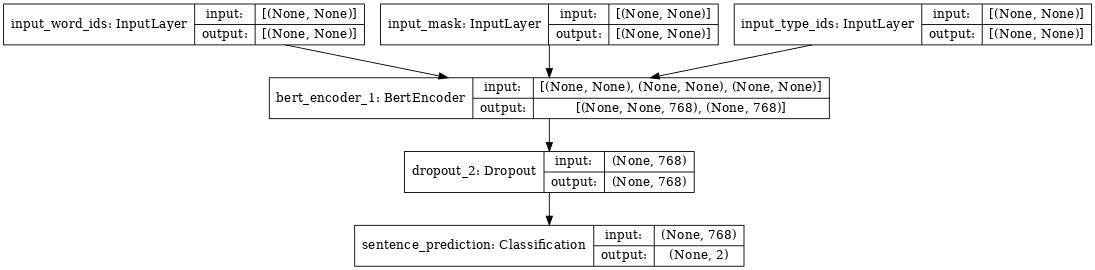

In [49]:
tf.keras.utils.plot_model(hub_classifier, show_shapes=True, dpi=64)

In [50]:
try:
  tf.keras.utils.plot_model(hub_encoder, show_shapes=True, dpi=64)
  assert False
except Exception as e:
  print(f"{type(e).__name__}: {e}")

AttributeError: 'KerasLayer' object has no attribute 'layers'


<a id="model_builder_functions"></a>

### Low level model building

If you need a more control over the construction of the model it's worth noting that the `classifier_model` function used earlier is really just a thin wrapper over the `nlp.modeling.networks.BertEncoder` and `nlp.modeling.models.BertClassifier` classes. Just remember that if you start modifying the architecture it may not be correct or possible to reload the pre-trained checkpoint so you'll need to retrain from scratch.

Build the encoder:

In [51]:
bert_encoder_config = config_dict.copy()

# You need to rename a few fields to make this work:
bert_encoder_config['attention_dropout_rate'] = bert_encoder_config.pop('attention_probs_dropout_prob')
bert_encoder_config['activation'] = tf_utils.get_activation(bert_encoder_config.pop('hidden_act'))
bert_encoder_config['dropout_rate'] = bert_encoder_config.pop('hidden_dropout_prob')
bert_encoder_config['initializer'] = tf.keras.initializers.TruncatedNormal(
          stddev=bert_encoder_config.pop('initializer_range'))
bert_encoder_config['max_sequence_length'] = bert_encoder_config.pop('max_position_embeddings')
bert_encoder_config['num_layers'] = bert_encoder_config.pop('num_hidden_layers')

bert_encoder_config

{'hidden_size': 768,
 'intermediate_size': 3072,
 'num_attention_heads': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522,
 'attention_dropout_rate': 0.1,
 'activation': <function official.modeling.activations.gelu.gelu(x)>,
 'dropout_rate': 0.1,
 'initializer': <keras.initializers.initializers_v2.TruncatedNormal at 0x7f006c251d10>,
 'max_sequence_length': 512,
 'num_layers': 12}

In [52]:
manual_encoder = nlp.modeling.networks.BertEncoder(**bert_encoder_config)

Restore the weights:

In [53]:
checkpoint = tf.train.Checkpoint(encoder=manual_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Test run it:

In [54]:
result = manual_encoder(my_examples, training=True)

print("Sequence output shape:", result[0].shape)
print("Pooled output shape:", result[1].shape)

Sequence output shape: (2, 23, 768)
Pooled output shape: (2, 768)


Wrap it in a classifier:

In [55]:
manual_classifier = nlp.modeling.models.BertClassifier(
        bert_encoder,
        num_classes=2,
        dropout_rate=bert_encoder_config['dropout_rate'],
        initializer=bert_encoder_config['initializer'])

In [56]:
manual_classifier(my_examples, training=True).numpy()

array([[ 0.19574928, -0.09590703],
       [-0.3455575 ,  0.12091695]], dtype=float32)

<a id="optimizer_schedule"></a>

### Optimizers and schedules

The optimizer used to train the model was created using the `nlp.optimization.create_optimizer` function:

In [57]:
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

That high level wrapper sets up the learning rate schedules and the optimizer.

The base learning rate schedule used here is a linear decay to zero over the training run:

In [58]:
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs

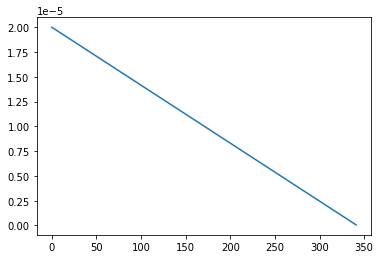

In [59]:
decay_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=2e-5,
      decay_steps=num_train_steps,
      end_learning_rate=0)

plt.plot([decay_schedule(n) for n in range(num_train_steps)])

This, in turn is wrapped in a `WarmUp` schedule that linearly increases the learning rate to the target value over the first 10% of training:

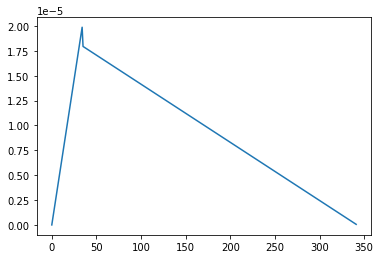

In [60]:
warmup_steps = num_train_steps * 0.1

warmup_schedule = nlp.optimization.WarmUp(
        initial_learning_rate=2e-5,
        decay_schedule_fn=decay_schedule,
        warmup_steps=warmup_steps)

# The warmup overshoots, because it warms up to the `initial_learning_rate`
# following the original implementation. You can set
# `initial_learning_rate=decay_schedule(warmup_steps)` if you don't like the
# overshoot.
plt.plot([warmup_schedule(n) for n in range(num_train_steps)])

Then create the `nlp.optimization.AdamWeightDecay` using that schedule, configured for the BERT model:

In [61]:
optimizer = nlp.optimization.AdamWeightDecay(
        learning_rate=warmup_schedule,
        weight_decay_rate=0.01,
        epsilon=1e-6,
        exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])